## $\beta$ VAE

To Do:
1. Formulation for Beta VAE:
1. Formulation for capacity controlled Beta VAE
1. Advantages for Beta VAE over vanilla VAE. Locality, Disentanglement

Dataset: https://github.com/deepmind/dsprites-dataset

In [1]:
!if [ -d VAE ]; then rm -Rf VAE; fi
!git clone https://github.com/KayEs141193/VAE.git
!pip install ./VAE

Cloning into 'VAE'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 188 (delta 103), reused 153 (delta 68), pack-reused 0
Receiving objects: 100% (188/188), 880.62 KiB | 1.01 MiB/s, done.
Resolving deltas: 100% (103/103), done.
Processing ./VAE
  Created wheel for VAE: filename=VAE-0.1-cp36-none-any.whl size=7749 sha256=3d9b39255c1a61dee55f6bde62db4d95d461960c112b6748f86b3850705b34c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-4_wl0owj/wheels/87/c4/92/54bf6a888c3c84c94c915ad1065b66b06a7224aaca6a6e9287
Successfully built VAE
  Found existing installation: VAE 0.1
    Uninstalling VAE-0.1:
      Successfully uninstalled VAE-0.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from VAE.models import ConvVAE
from VAE.utils import print_and_collect, plot_results, latent_analysis
from VAE.trainer import create_basic_trainer, create_basic_evaluator, create_lanalysis_trainer
from VAE.loss import log_prob_ratio_normal, recon_loss_bernoulli, makeLossLayered
import ignite
from ignite.engine import Engine, Events
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torchvision.utils import make_grid
from IPython.display import display
import torchvision.transforms as T

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

num_workers = 8 if cuda else 0

In [4]:
# Setting up the data set

data = np.load('dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz',allow_pickle=True, encoding='latin1')
print('KEYS:',list(data.keys()))
print(data['metadata'])

KEYS: ['metadata', 'imgs', 'latents_classes', 'latents_values']
{'date': 'April 2017', 'description': 'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', 'version': 1, 'latents_names': ('color', 'shape', 'scale', 'orientation', 'posX', 'posY'), 'latents_possible_values': {'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       3.22214631, 3.38325363, 3.54436094, 3.70546826, 

In [5]:
idx = np.argwhere( ( (data['latents_classes'][:,1]==0) & (data['latents_classes'][:,3]==0) ) ) # 6144
imgs = data['imgs'][idx]
imgs = imgs[np.random.permutation(np.arange(len(imgs)))]

train_len = 5000
val_len = 1144
batch_size = 256

train_data = (torch.tensor(imgs[:train_len],dtype=torch.float) )
val_data = (torch.tensor(imgs[train_len:train_len+val_len],dtype=torch.float) )
                          
train_loader = DataLoader(train_data,shuffle=True,batch_size=batch_size,num_workers=num_workers)
val_loader = DataLoader(val_data,shuffle=True,batch_size=batch_size,num_workers=num_workers)

img0 = torch.tensor(imgs[0],device=device,dtype=torch.float)

In [6]:
def convertToImage(x):
    """ Convert 4D tensor to 4D numpy
    """
    return (x>0).type(torch.int)

def collect_trains(engine,train_hist):
    metrics = engine.state.metrics
        
    for key in train_hist.keys():
        train_hist[key].append(metrics[key])

def plot_kl_componentwise(train_hist,latent_dim):

    for i in range(latent_dim):
        plt.plot(train_hist['kl_loss_'+str(i)],label='kl_loss_'+str(i))
    
    plt.legend()
    plt.ylabel('nats/dim')
    plt.xlabel('epochs')
    plt.title('KL loss for each Latent Dimension')

def plot_reconstructions(model,testdata):
  pairs = convertToImage(torch.stack([ a for p in zip(testdata[:50], model(testdata[:50].to(device))[0].cpu()) for a in p ],dim=0).detach())
  display(T.ToPILImage()(make_grid(pairs,nrow=10,pad_value=1).type(torch.float)))

def solution(train_hist,val_hist,train_loader,testdata,input_size,base_channel,config_enc,config_dec,latent_dim,lr,epochs,beta):
    
    model = ConvVAE.construct(input_size,base_channel,config_enc, config_dec, latent_dim, device)
    optimizer = optim.Adam(model.parameters(),lr=lr)
    lr_scheduler = StepLR(optimizer,100)

    def changeLR(engine):
        lr_scheduler.step()

    # Setup engines
    evaluator = create_basic_evaluator(model,device,beta=beta,recon_loss=recon_loss_bernoulli)
    trainer = create_lanalysis_trainer(model,optimizer,device,latent_dim,beta=beta,recon_loss=recon_loss_bernoulli,evaluator=evaluator,val_loader=val_loader)

    # Register handlers
    trainer.add_event_handler(Events.EPOCH_COMPLETED, print_and_collect, evaluator, val_loader, 'Validation', val_hist)
    trainer.add_event_handler(Events.EPOCH_COMPLETED, collect_trains, train_hist)
    trainer.add_event_handler(Events.EPOCH_COMPLETED, changeLR)

    # Run engine
    e = trainer.run(train_loader, max_epochs=epochs)

    return model, train_hist, val_hist

In [7]:
input_size = (64,64,1)
latent_dim = 10
base_channel = 32
config_enc = [{'channel':1,'kernel':3,'stride':1},{'channel':32,'kernel':3,'stride':2},{'channel':32,'kernel':3,'stride':2},{'channel':32,'kernel':3,'stride':2}]
config_dec = [{'channel':32,'kernel':4,'stride':2},{'channel':32,'kernel':4,'stride':2},{'channel':32,'kernel':4,'stride':2}]

train_hist = {'elbo_loss':[],'kl_loss':[],'recon_loss':[]}
val_hist = {'elbo_loss':[],'kl_loss':[],'recon_loss':[]}

for i in range(latent_dim):
    train_hist['kl_loss_'+str(i)] = []

lr = 0.001
epochs = 400
beta = 1

model, train_hist, val_hist = solution(train_hist,val_hist,train_loader,val_loader,input_size,base_channel,config_enc,config_dec,latent_dim,lr,epochs,beta)

Validation Results - Epoch 1 - ELBO loss: 1072.91 RECON loss: 1063.40 KL loss: 9.51
Validation Results - Epoch 2 - ELBO loss: 863.85 RECON loss: 859.81 KL loss: 4.04
Validation Results - Epoch 3 - ELBO loss: 719.91 RECON loss: 697.49 KL loss: 22.42
Validation Results - Epoch 4 - ELBO loss: 699.28 RECON loss: 686.29 KL loss: 12.99
Validation Results - Epoch 5 - ELBO loss: 694.19 RECON loss: 684.15 KL loss: 10.04
Validation Results - Epoch 6 - ELBO loss: 692.30 RECON loss: 682.27 KL loss: 10.03
Validation Results - Epoch 7 - ELBO loss: 689.89 RECON loss: 681.53 KL loss: 8.36
Validation Results - Epoch 8 - ELBO loss: 687.94 RECON loss: 679.32 KL loss: 8.62
Validation Results - Epoch 9 - ELBO loss: 684.20 RECON loss: 676.35 KL loss: 7.85
Validation Results - Epoch 10 - ELBO loss: 681.86 RECON loss: 674.07 KL loss: 7.79
Validation Results - Epoch 11 - ELBO loss: 675.52 RECON loss: 667.69 KL loss: 7.83
Validation Results - Epoch 12 - ELBO loss: 640.27 RECON loss: 632.82 KL loss: 7.45
Validat

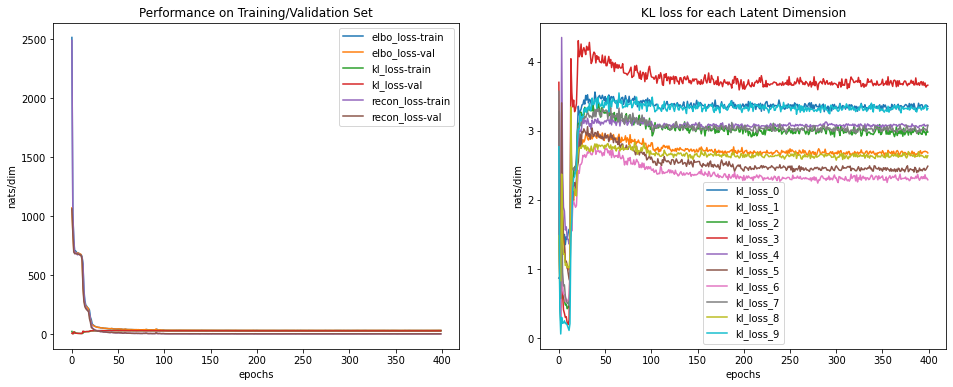

In [8]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_results(train_hist,val_hist,val_hist.keys())
plt.subplot(1,2,2)
plot_kl_componentwise(train_hist,latent_dim)

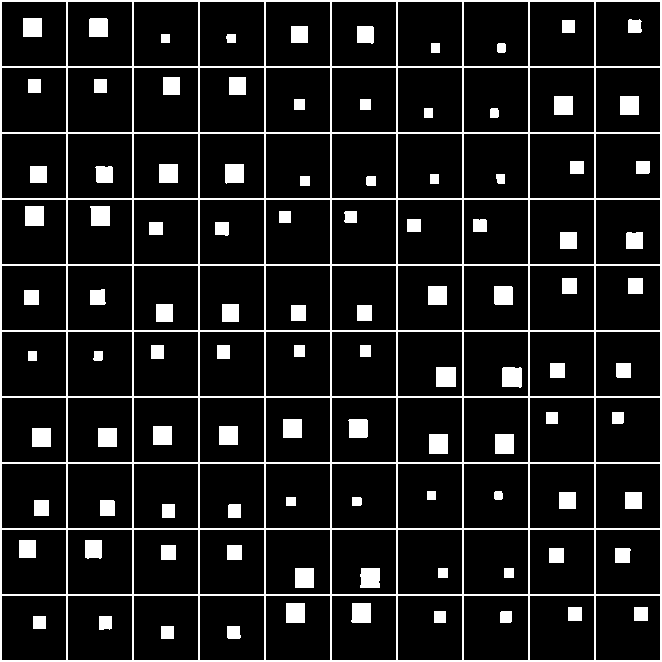

In [9]:
plot_reconstructions(model,val_data)

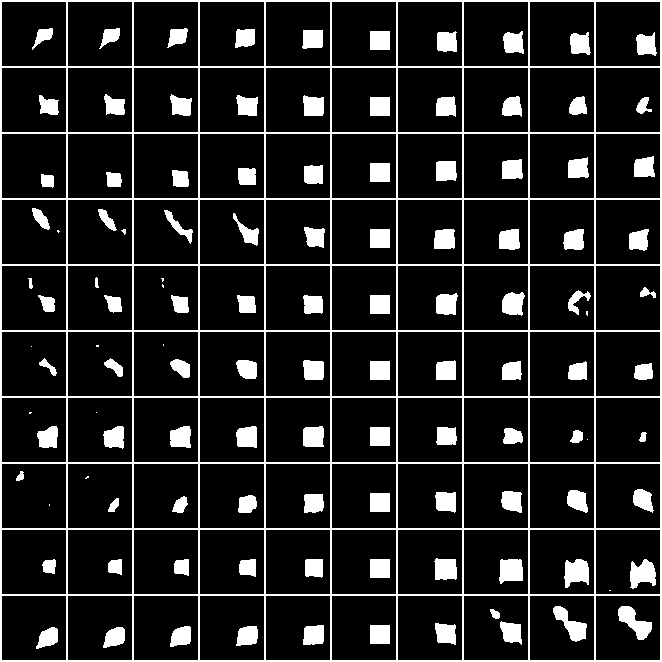

In [38]:
res = torch.cat([latent_analysis(img0,model,i,(np.arange(10)-5),False,device) for i in range(10)])
display(T.ToPILImage()(make_grid(convertToImage(res.cpu().detach()),nrow=10,pad_value=1).type(torch.float)))

In [31]:
input_size = (64,64,1)
latent_dim = 10
base_channel = 32
config_enc = [{'channel':1,'kernel':3,'stride':1},{'channel':32,'kernel':3,'stride':2},{'channel':32,'kernel':3,'stride':2},{'channel':32,'kernel':3,'stride':2}]
config_dec = [{'channel':32,'kernel':4,'stride':2},{'channel':32,'kernel':4,'stride':2},{'channel':32,'kernel':4,'stride':2}]

train_hist1 = {'elbo_loss':[],'kl_loss':[],'recon_loss':[]}
val_hist1 = {'elbo_loss':[],'kl_loss':[],'recon_loss':[]}

for i in range(latent_dim):
    train_hist1['kl_loss_'+str(i)] = []

lr = 0.001
epochs = 200
beta = 150

model1, train_hist1, val_hist1 = solution(train_hist1,val_hist1,train_loader,val_loader,input_size,base_channel,config_enc,config_dec,latent_dim,lr,epochs,beta)

Validation Results - Epoch 1 - ELBO loss: 1316.55 RECON loss: 1312.77 KL loss: 0.03
Validation Results - Epoch 2 - ELBO loss: 1018.63 RECON loss: 1017.64 KL loss: 0.01
Validation Results - Epoch 3 - ELBO loss: 914.60 RECON loss: 914.01 KL loss: 0.00
Validation Results - Epoch 4 - ELBO loss: 822.73 RECON loss: 821.63 KL loss: 0.01
Validation Results - Epoch 5 - ELBO loss: 745.93 RECON loss: 745.28 KL loss: 0.00
Validation Results - Epoch 6 - ELBO loss: 716.44 RECON loss: 716.08 KL loss: 0.00
Validation Results - Epoch 7 - ELBO loss: 697.17 RECON loss: 696.99 KL loss: 0.00
Validation Results - Epoch 8 - ELBO loss: 692.22 RECON loss: 692.13 KL loss: 0.00
Validation Results - Epoch 9 - ELBO loss: 687.24 RECON loss: 687.20 KL loss: 0.00
Validation Results - Epoch 10 - ELBO loss: 685.65 RECON loss: 685.63 KL loss: 0.00
Validation Results - Epoch 11 - ELBO loss: 683.82 RECON loss: 683.81 KL loss: 0.00
Validation Results - Epoch 12 - ELBO loss: 682.05 RECON loss: 682.04 KL loss: 0.00
Validatio

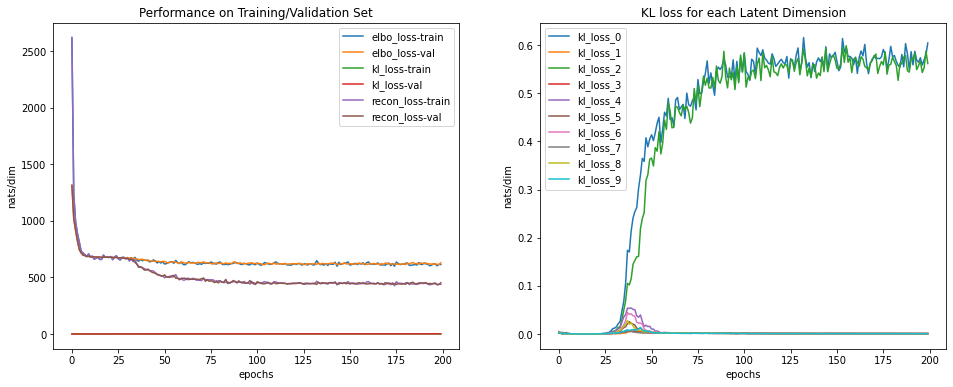

In [32]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_results(train_hist1,val_hist1,val_hist1.keys())
plt.subplot(1,2,2)
plot_kl_componentwise(train_hist1,latent_dim)

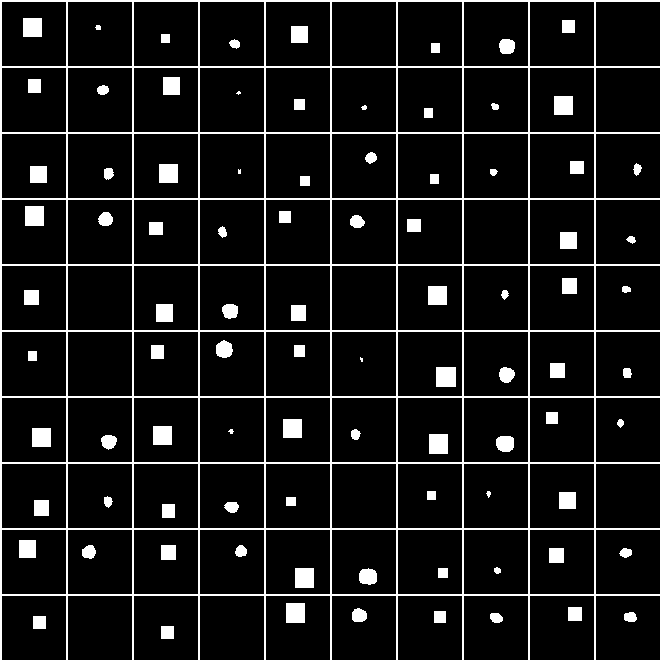

In [33]:
plot_reconstructions(model1,val_data)

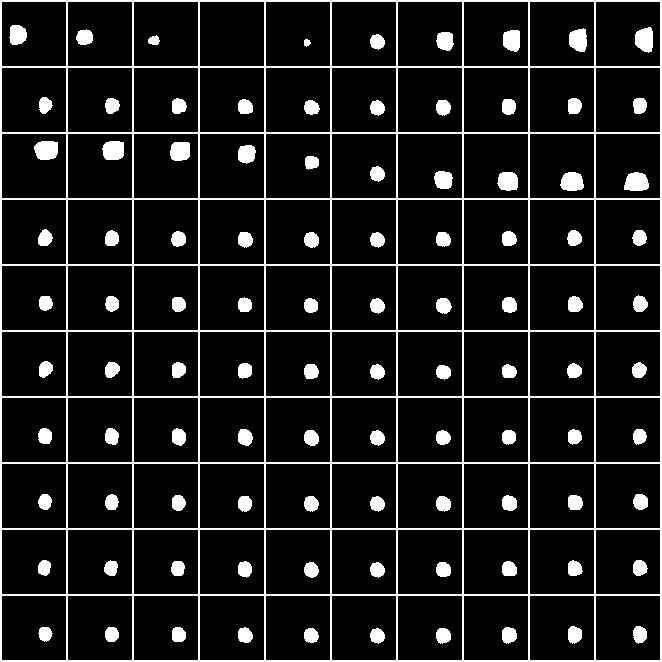

In [37]:
res1 = torch.cat([latent_analysis(img0,model1,i,(np.arange(10)-5),False,device) for i in range(10)])
display(T.ToPILImage()(make_grid(convertToImage(res1.cpu().detach()),nrow=10,pad_value=1).type(torch.float)))